# Objective: Read and plot GMSH file

* Started from Aurélie's notebook of first exploration of gmsh python package ( https://github.com/auraoupa/plots_nextsim/blob/main/plots-on-dahu/2022-10-12-AA-reproduce-gmsh-with-python.ipynb )

* This notebook explores different ways to read the gmsh file and plot elements by partitions: 
__To plot triangles, run section 1 (initialization) then go to section 5 (triangles)__

### Dahu@GRICAD cheatsheet:
This notebook runs on Dahu@Gricad. 
```
# On Dahu:
lerouste@f-dahu:~$ oarsub -I --project data-ocean -l /core=5,walltime=1:30:00
#
# Then on the computing node:
# Activate conda environment
(SIaa) lerouste@dahu103:/bettik/lerouste$ conda activate /bettik/lerouste/.conda/envs/SIaa
#
# Launch notebook:
(SIaa) lerouste@dahu103:/bettik/lerouste$ jupyter notebook --port 2017 
```

* To allow display forwarding on my local laptop, run this in a local terminal:
```
leroux@mcp-oceannext-03:~>> ssh -fNL 2017:dahu103:2017 dahu.ciment
```

### Super useful example/doc: 
  
https://gitlab.onelab.info/gmsh/gmsh/blob/gmsh_4_9_5/tutorials/python/x1.py

In [1]:
import gmsh
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import cm, patches, collections

## 1. Initialization

In [2]:
mesh_file='/bettik/alberta/small-arctic-10km-sidfex/experiments/run_330d_partnodisk/par32small_arctic_10km.msh'

In [3]:
gmsh.initialize()
file = gmsh.open(mesh_file)

Info    : Reading '/bettik/alberta/small-arctic-10km-sidfex/experiments/run_330d_partnodisk/par32small_arctic_10km.msh'...
Info    : 65350 nodes
Info    : 128912 elements
Info    : Converting old partitioning...                                   
Info    : Creating partition topology...
Info    :  - Creating partition curves
Info    :  - Creating partition points
Info    : Done creating partition topology
Info    : Done reading '/bettik/alberta/small-arctic-10km-sidfex/experiments/run_330d_partnodisk/par32small_arctic_10km.msh'


In [4]:
# Number of partitions (i.e. as many partitions as processors on which the simulation has run)
NP =  gmsh.model.getNumberOfPartitions()
NP

# Get all Entities from gmsh file
entities = gmsh.model.getEntities()

## 2. Print types of Entities we have in the file:

In [5]:
for e in entities:
    if (gmsh.model.getType(e[0], e[1])=="Partition point"):
        partitions = gmsh.model.getPartitions(e[0], e[1])
    
        if len(partitions):
            print("Entity " + str(e) + " of type " +
              gmsh.model.getType(e[0], e[1]))
            print(" - Partition(s): " + str(partitions))
            print(" - Parent: " + str(gmsh.model.getParent(e[0], e[1])))
            print(" - Boundary: " + str(gmsh.model.getBoundary([e])))



Entity (0, 39) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -38)
 - Boundary: []
Entity (0, 40) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -37)
 - Boundary: []
Entity (0, 41) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -36)
 - Boundary: []
Entity (0, 42) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -35)
 - Boundary: []
Entity (0, 43) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -34)
 - Boundary: []
Entity (0, 44) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -33)
 - Boundary: []
Entity (0, 45) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -32)
 - Boundary: []
Entity (0, 46) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -31)
 - Boundary: []
Entity (0, 47) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -30)
 - Boundary: []
Entity (0, 48) of type Partition point
 - Partition(s): [1]
 - Parent: (0, -29)
 - Boundary: []
Entity (0, 49) of type Partition point
 

Entity (0, 1647) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1648) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1649) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1650) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1651) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1652) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1653) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1654) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1655) of type Partition point
 - Partition(s): [ 1  7 14]
 - Parent: (1, -59)
 - Boundary: []
Entity (0, 1656) of type Partition point
 - Partition(s

## 3. Loop over "Partition surface" entities and get coordinates of the  nodes for each partition separately

In [6]:
bignodes_x = np.zeros((NP,5000))
bignodes_y = np.zeros((NP,5000))
bigindices = np.zeros((NP,5000))


for ipart in range(0,NP):
    icount=-1
    for e in entities:
        if (gmsh.model.getType(e[0], e[1])=="Partition surface"):
            print("Entity " + str(e) + " of type " + gmsh.model.getType(e[0], e[1]))
            # get the mesh nodes for each elementary entity
            nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(e[0], e[1])
        
        #x = dict(zip(nodeTags, nodeCoords[0::3]))
        #y = dict(zip(nodeTags, nodeCoords[1::3]))
        #z = dict(zip(nodeTags, nodeCoords[2::3]))
        #print(len(x))
        # get the mesh elements for each elementary entity
        #elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(e[0], e[1])
        # count number of elements
        #numElem = sum(len(i) for i in elemTags)
        #print(" - mesh has " + str(len(nodeTags)) + " nodes and " + str(numElem) +
        #  " elements")
        #boundary = gmsh.model.getBoundary([e])
        #print(" - boundary entities " + str(boundary))
            partitions = gmsh.model.getPartitions(e[0], e[1])
            print(" - Partition tag(s): " + str(partitions))
            if len(partitions):
                if ipart in partitions:
                    print(" - Partition tag(s): " + str(partitions))
                    bignodes_x[ipart,:len(nodeCoords[0::3])] = nodeCoords[0::3]
                    bignodes_y[ipart,:len(nodeCoords[1::3])] = nodeCoords[1::3]
                
                

Entity (2, 1) of type Partition surface
 - Partition tag(s): [22]
Entity (2, 2) of type Partition surface
 - Partition tag(s): [26]
Entity (2, 3) of type Partition surface
 - Partition tag(s): [25]
Entity (2, 4) of type Partition surface
 - Partition tag(s): [21]
Entity (2, 5) of type Partition surface
 - Partition tag(s): [2]
Entity (2, 6) of type Partition surface
 - Partition tag(s): [1]
Entity (2, 7) of type Partition surface
 - Partition tag(s): [4]
Entity (2, 8) of type Partition surface
 - Partition tag(s): [6]
Entity (2, 9) of type Partition surface
 - Partition tag(s): [5]
Entity (2, 10) of type Partition surface
 - Partition tag(s): [7]
Entity (2, 11) of type Partition surface
 - Partition tag(s): [8]
Entity (2, 12) of type Partition surface
 - Partition tag(s): [14]
Entity (2, 13) of type Partition surface
 - Partition tag(s): [13]
Entity (2, 14) of type Partition surface
 - Partition tag(s): [16]
Entity (2, 15) of type Partition surface
 - Partition tag(s): [12]
Entity (2, 

 - Partition tag(s): [1]
Entity (2, 7) of type Partition surface
 - Partition tag(s): [4]
Entity (2, 8) of type Partition surface
 - Partition tag(s): [6]
Entity (2, 9) of type Partition surface
 - Partition tag(s): [5]
Entity (2, 10) of type Partition surface
 - Partition tag(s): [7]
Entity (2, 11) of type Partition surface
 - Partition tag(s): [8]
Entity (2, 12) of type Partition surface
 - Partition tag(s): [14]
Entity (2, 13) of type Partition surface
 - Partition tag(s): [13]
Entity (2, 14) of type Partition surface
 - Partition tag(s): [16]
Entity (2, 15) of type Partition surface
 - Partition tag(s): [12]
Entity (2, 16) of type Partition surface
 - Partition tag(s): [15]
 - Partition tag(s): [15]
Entity (2, 17) of type Partition surface
 - Partition tag(s): [9]
Entity (2, 18) of type Partition surface
 - Partition tag(s): [10]
Entity (2, 19) of type Partition surface
 - Partition tag(s): [20]
Entity (2, 20) of type Partition surface
 - Partition tag(s): [11]
Entity (2, 21) of ty

In [7]:
gmsh.model.mesh.get_elements

<function gmsh.model.mesh.getElements(dim=-1, tag=-1)>

### Plot all nodes in each of the NP partitions:

[]

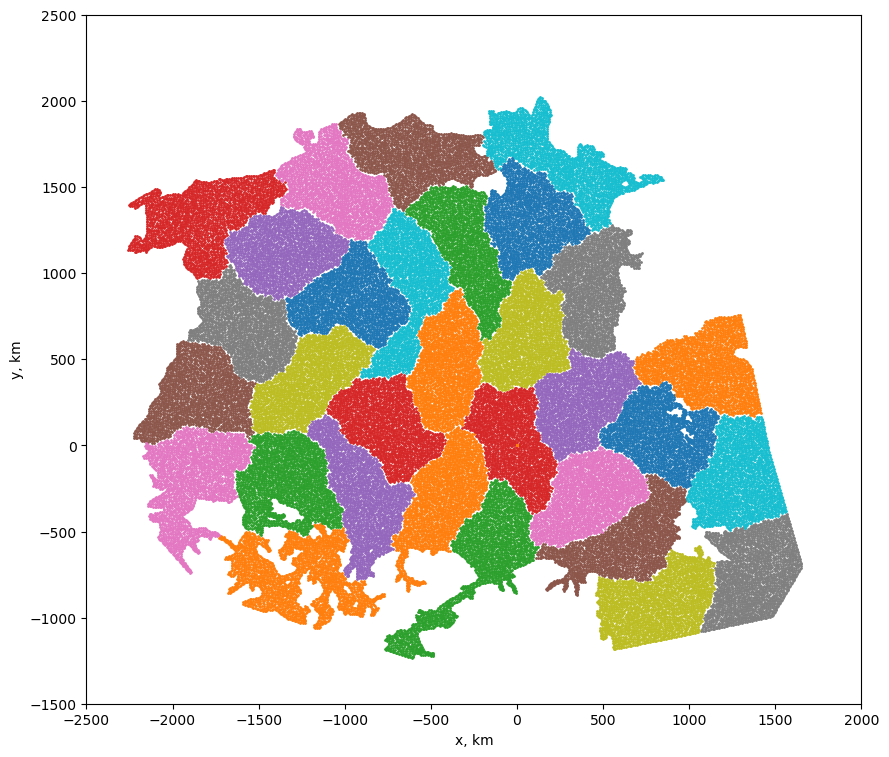

In [8]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
fig = ax.figure

sfac=1e-3
cmap='jet'




for ip in range(0,NP):
    plt.scatter(sfac*bignodes_x[ip,:].squeeze(), sfac*bignodes_y[ip,:].squeeze(),marker=".",s=4)

ax.set_aspect('equal')

ax.set_xlabel('x, km')
ax.set_ylabel('y, km')

#ax.set_xlim(-500,1500)
#ax.set_ylim(-1500,500)
ax.set_xlim(-2500,2000)
ax.set_ylim(-1500,2500)

#cbar  = fig.colorbar(pc, ax=ax, orientation="vertical", pad=0.01, shrink=0.5)

plt.plot()

## 4. Loop over "Partition point" entities and get coordinates of all the corresponding  nodes

In [9]:
    bignodes_xp = np.zeros((2262))
    bignodes_yp = np.zeros((2262))

    icount=-1
    for e in entities:
        if (gmsh.model.getType(e[0], e[1])=="Partition point"):
            print("Entity " + str(e) + " of type " + gmsh.model.getType(e[0], e[1]))
            # get the mesh nodes for each elementary entity
            nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(e[0], e[1])
            partitions = gmsh.model.getPartitions(e[0], e[1])
            print(" - Partition tag(s): " + str(partitions))
            if len(nodeCoords):
                icount=icount+1
            #        print(" - Partition tag(s): " + str(partitions))
                bignodes_xp[icount] = nodeCoords[0]
                bignodes_yp[icount] = nodeCoords[1]
                
    print(icount)          

Entity (0, 39) of type Partition point
 - Partition tag(s): [1]
Entity (0, 40) of type Partition point
 - Partition tag(s): [1]
Entity (0, 41) of type Partition point
 - Partition tag(s): [1]
Entity (0, 42) of type Partition point
 - Partition tag(s): [1]
Entity (0, 43) of type Partition point
 - Partition tag(s): [1]
Entity (0, 44) of type Partition point
 - Partition tag(s): [1]
Entity (0, 45) of type Partition point
 - Partition tag(s): [1]
Entity (0, 46) of type Partition point
 - Partition tag(s): [1]
Entity (0, 47) of type Partition point
 - Partition tag(s): [1]
Entity (0, 48) of type Partition point
 - Partition tag(s): [1]
Entity (0, 49) of type Partition point
 - Partition tag(s): [1]
Entity (0, 50) of type Partition point
 - Partition tag(s): [1]
Entity (0, 51) of type Partition point
 - Partition tag(s): [1]
Entity (0, 52) of type Partition point
 - Partition tag(s): [1]
Entity (0, 53) of type Partition point
 - Partition tag(s): [1]
Entity (0, 54) of type Partition point
 

 - Partition tag(s): [ 1  7 14]
Entity (0, 1679) of type Partition point
 - Partition tag(s): [ 1  7 14]
Entity (0, 1680) of type Partition point
 - Partition tag(s): [ 1  7 14]
Entity (0, 1681) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1682) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1683) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1684) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1685) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1686) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1687) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1688) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1689) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1690) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1691) of type Partition point
 - Partition tag(s): [1 3 4]
Entity (0, 1692) of type Partition point
 - Partitio

### Plot all nodes in each of the NP partitions (in colors) and also the nodes at the boundaries of the partitions (in black):

[]

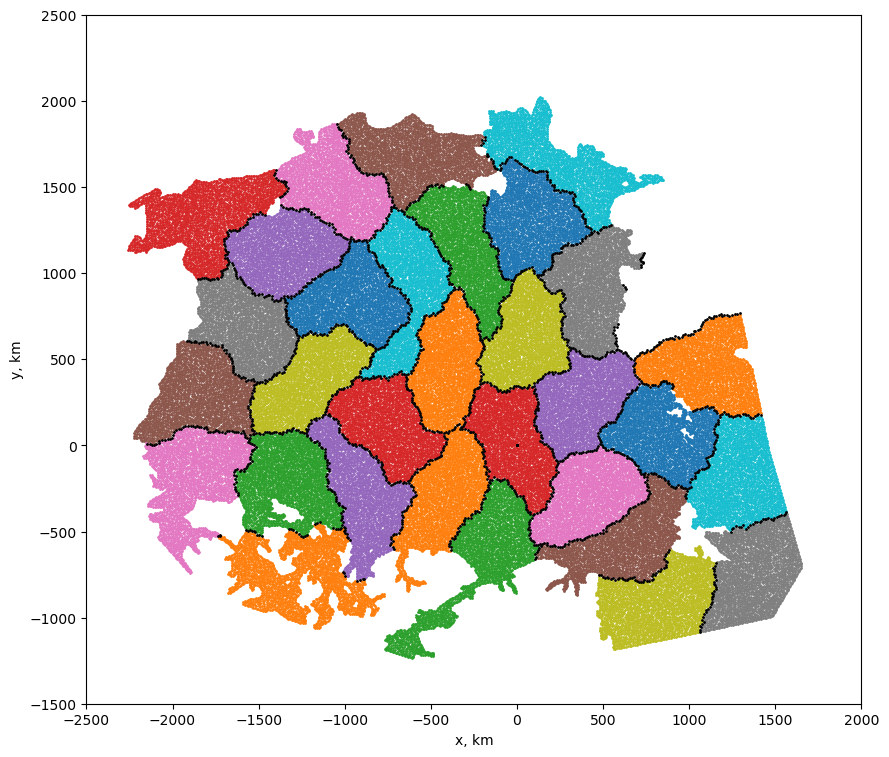

In [10]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
fig = ax.figure

sfac=1e-3
cmap='jet'

for ip in range(0,NP):
    plt.scatter(sfac*bignodes_x[ip,:].squeeze(), sfac*bignodes_y[ip,:].squeeze(),marker=".",s=4)
    
plt.scatter(sfac*bignodes_xp[:].squeeze(), sfac*bignodes_yp[:].squeeze(),marker=".",s=4,color='k')

ax.set_aspect('equal')

ax.set_xlabel('x, km')
ax.set_ylabel('y, km')

#ax.set_xlim(-500,1500)
#ax.set_ylim(-1500,500)
ax.set_xlim(-2500,2000)
ax.set_ylim(-1500,2500)

#cbar  = fig.colorbar(pc, ax=ax, orientation="vertical", pad=0.01, shrink=0.5)

plt.plot()

## 5 Now get  triangles for each partitions:

* First define a few functions

In [37]:
def GetPartitionsFromEntities(entities,NP):
    """ Gets mesh triangles and nodes coordinates from reading the entities of a gmsh file.
    
    Reads all entities from the gmsh model and look for "Partition surfaces". Loops over the partitions 
    and gets for each partition, all the nodes includes in the partitions (reads their x,y coordinates) 
    and all the mesh elements corresponding to this partitions (i.e. the triangles).
    
    Parameters
    ----------
    entities : Previously read from gmsh file 
        with 'entities = gmsh.model.getEntities()'

    NP : int
        Number of partitions (read from gmsh file with
        'NP=gmsh.model.getNumberOfPartitions()'
        
    Returns
    -------
    3 array_like of size NPx5000
        bigelemtags,bignodes_x,bignodes_y
        containing , for each of the NP partition, the tag of each elements, the x and y coordinates of each node.
    """
    bignodes_x = np.zeros((NP,5000))
    bignodes_y = np.zeros((NP,5000))
    bigelemtags = np.zeros((NP,5000))
    for ipart in range(0,NP):
        icount=-1
        for e in entities:
            if (gmsh.model.getType(e[0], e[1])=="Partition surface"):
                print("Entity " + str(e) + " of type " + gmsh.model.getType(e[0], e[1]))
                partitions = gmsh.model.getPartitions(e[0], e[1])
                print(" - Partition tag(s): " + str(partitions))
                if len(partitions):
                    if ipart in partitions:
                        # get the mesh nodes for each elementary entity
                        nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(e[0], e[1])
                        # Get the mesh elements for the entity (dim, tag):
                        elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(e[0], e[1])
                        print(" - Partition tag(s): " + str(partitions))
                        # save x,y coordinates of all nodes in the given partition (ipart)
                        bignodes_x[ipart,:len(nodeCoords[0::3])] = nodeCoords[0::3]
                        bignodes_y[ipart,:len(nodeCoords[1::3])] = nodeCoords[1::3]
                        # save the elements tag in the given partition
                        bigelemtags[ipart,:len(elemTags[0])] = elemTags[0]
    return bigelemtags,bignodes_x,bignodes_y


def preparecollection4plt(patchlist,c):
    """ Prepare to plot the patch for each partiton
    
    
    Parameters
    ----------
    patchlist : computed from makecollectionpart

    c : hex color
        color to plot the partition with
        
    Returns
    -------
    pc the patch collection to plot
        

    """
    pc = collections.PatchCollection(patchlist, cmap='binary', alpha=1)
    pc.set_array(np.zeros(1))
    pc.set_edgecolor(c)
    return pc

def makecollectionpart(bigelemtags,ipart,sfac):
    """ Collect all triangles to plot for a given partiton
    
    
    Parameters
    ----------
    bigelemtags : array of all tags of elements corresponding to each of the NP partitons

    ipart : int 
        partition index
    
    sfac  : float
        
        scale factor to convert the coordinates with (for example from m to km)
    Returns
    -------
    patch_list corresponding to the given partition
        
    """

    #Set up the triangles
    patch_list  = []
    rgba_list = []
    nodes1_x = []
    nodes1_y = []
    nodes2_x = []
    nodes2_y = []
    nodes3_x = []
    nodes3_y = []
    part = []
    tag = []

    for t in np.arange(len(bigelemtags[ipart,:])):
        #print(t)
        tag1 = int(bigelemtags[ipart,t])
        if tag1>0:
            eltyp,nodetags,dim,tag2 = gmsh.model.mesh.get_element(tag1)
            part.append(tag2)

            tag.append(t)

            n1=gmsh.model.mesh.get_node(nodetags[0])
            n1_coord=n1[0]
            n1_x=n1_coord[0]*sfac
            n1_y=n1_coord[1]*sfac
            nodes1_x.append(n1_x)
            nodes1_y.append(n1_y)

            n2=gmsh.model.mesh.get_node(nodetags[1])
            n2_coord=n2[0]
            n2_x=n2_coord[0]*sfac
            n2_y=n2_coord[1]*sfac
            nodes2_x.append(n2_x)
            nodes2_y.append(n2_y)

            n3=gmsh.model.mesh.get_node(nodetags[2])
            n3_coord=n3[0]
            n3_x=n3_coord[0]*sfac
            n3_y=n3_coord[1]*sfac
            nodes3_x.append(n3_x)
            nodes3_y.append(n3_y)

            ccl   = []
            ccl.append((n1_x,n1_y))
            ccl.append((n2_x,n2_y))
            ccl.append((n3_x,n3_y))
            ccl.append(ccl[0])
            
            patch_list.append(patches.Polygon(ccl,True,linewidth=0))
    return patch_list        



* Loop over "Partition surface" entities and get coordinates of the  nodes for each partition separately. Also save element tags of the elements in  each partitions. From those tags, we can use Aurélie's code to retieve them and plot them in different colors.

In [38]:
bigelemtags,bignodes_x,bignodes_y = GetPartitionsFromEntities(entities,NP)               

Entity (2, 1) of type Partition surface
 - Partition tag(s): [22]
Entity (2, 2) of type Partition surface
 - Partition tag(s): [26]
Entity (2, 3) of type Partition surface
 - Partition tag(s): [25]
Entity (2, 4) of type Partition surface
 - Partition tag(s): [21]
Entity (2, 5) of type Partition surface
 - Partition tag(s): [2]
Entity (2, 6) of type Partition surface
 - Partition tag(s): [1]
Entity (2, 7) of type Partition surface
 - Partition tag(s): [4]
Entity (2, 8) of type Partition surface
 - Partition tag(s): [6]
Entity (2, 9) of type Partition surface
 - Partition tag(s): [5]
Entity (2, 10) of type Partition surface
 - Partition tag(s): [7]
Entity (2, 11) of type Partition surface
 - Partition tag(s): [8]
Entity (2, 12) of type Partition surface
 - Partition tag(s): [14]
Entity (2, 13) of type Partition surface
 - Partition tag(s): [13]
Entity (2, 14) of type Partition surface
 - Partition tag(s): [16]
Entity (2, 15) of type Partition surface
 - Partition tag(s): [12]
Entity (2, 

Entity (2, 1) of type Partition surface
 - Partition tag(s): [22]
Entity (2, 2) of type Partition surface
 - Partition tag(s): [26]
Entity (2, 3) of type Partition surface
 - Partition tag(s): [25]
Entity (2, 4) of type Partition surface
 - Partition tag(s): [21]
 - Partition tag(s): [21]
Entity (2, 5) of type Partition surface
 - Partition tag(s): [2]
Entity (2, 6) of type Partition surface
 - Partition tag(s): [1]
Entity (2, 7) of type Partition surface
 - Partition tag(s): [4]
Entity (2, 8) of type Partition surface
 - Partition tag(s): [6]
Entity (2, 9) of type Partition surface
 - Partition tag(s): [5]
Entity (2, 10) of type Partition surface
 - Partition tag(s): [7]
Entity (2, 11) of type Partition surface
 - Partition tag(s): [8]
Entity (2, 12) of type Partition surface
 - Partition tag(s): [14]
Entity (2, 13) of type Partition surface
 - Partition tag(s): [13]
Entity (2, 14) of type Partition surface
 - Partition tag(s): [16]
Entity (2, 15) of type Partition surface
 - Partitio

* Then create a big list collection the NP lists  corresponding to the patches to plot for a each partition

In [39]:
# scale factor so that x and y are in km instead of m
sfac=1e-3

# initialize a list that will collect the NP lists corresponding to each of the NP partitions
allpatchlists=[]

# loop on the partitions
for ipart in range(0,NP):
    allpatchlists.append(makecollectionpart(bigelemtags,ipart,sfac))


/tmp/ipykernel_3357285/193295509.py:83: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patch_list.append(patches.Polygon(ccl,True,linewidth=0))


* Plot the triangles of each partition in a given color

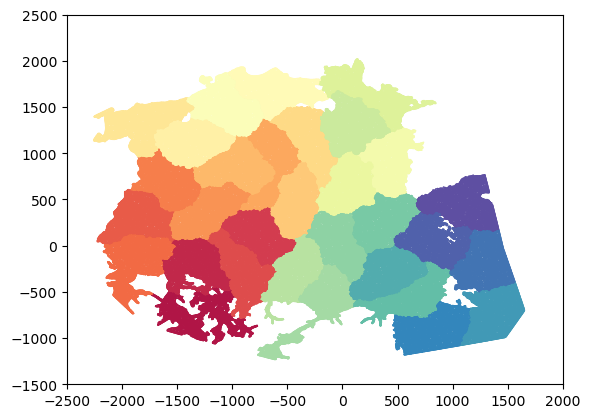

In [40]:
# create a color_list of NP different colors
cmap = cm.get_cmap('Spectral', NP)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# create figure
ax = plt.figure().add_subplot(111)
fig = ax.figure

ax.set_xlim(-2500,2000)
ax.set_ylim(-1500,2500)

# loop on the NP partitions and plot the corresponding collection of patches with a given color
for ip in range(0,NP):
    ax.add_collection(preparecollection4plt(allpatchlists[ip],color_list[ip]))



* Zoom to better see the triangles

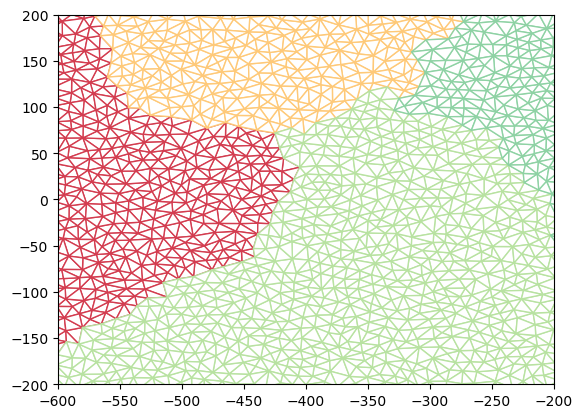

In [41]:

# create a color_list of NP different colors
cmap = cm.get_cmap('Spectral', NP)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# create figure
ax = plt.figure().add_subplot(111)
fig = ax.figure

ax.set_xlim(-600,-200)
ax.set_ylim(-200,200)

# loop on the NP partitions and plot the corresponding collection of patches with a given color
for ip in range(0,NP):
    ax.add_collection(preparecollection4plt(allpatchlists[ip],color_list[ip]))

